In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats as st

In [2]:
df = pd.read_csv('training.csv')
df.Target.sum()

278

In [269]:
df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_540,Feature_541,Feature_542,Feature_543,Feature_544,Feature_545,Feature_546,Feature_547,Feature_548,Target
0,0.144231,0.105263,0.9000,0.66665,0.93750,0.0,0.0,NaN,NaN,0.56250,...,0.216696,0.0000,0.000000,Orcs,0.3,0.0,0.294118,0.111111,0.0,0
1,0.115385,0.000000,0.8750,0.00000,0.94000,0.0,0.0,0.0,0.028192,0.56000,...,0.058615,0.0105,0.000000,Goblins,0.1,1.0,0.235294,0.222222,1.0,0
2,0.076923,0.000000,0.8750,0.50000,0.86665,0.0,1.0,0.0,0.027882,0.63335,...,0.000000,0.0000,0.263682,Uruk-hai,0.4,0.0,0.117647,0.222222,0.0,0
3,0.076923,0.000000,0.8750,0.00000,0.71430,0.0,0.0,0.0,NaN,0.78570,...,0.000000,0.0000,0.000000,Goblins,0.0,1.0,0.117647,0.222222,0.0,0
4,0.528846,0.263158,0.9375,0.87500,0.93135,0.0,1.0,0.0,0.027882,0.56865,...,0.033748,0.0130,0.094527,Uruk-hai,0.3,1.0,0.117647,0.666667,1.0,0


In [9]:
df.shape

(2563, 549)

In [10]:
# Mostrar variables numéricas
numeric_variables = df.select_dtypes(include=['number'])
print("Variables Numéricas:")
print(numeric_variables.columns)

# Mostrar variables categóricas
categorical_variables = df.select_dtypes(include=['object'])
print("\nVariables Categóricas:")
print(categorical_variables.columns)

Variables Numéricas:
Index(['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5',
       'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
       ...
       'Feature_539', 'Feature_540', 'Feature_541', 'Feature_542',
       'Feature_544', 'Feature_545', 'Feature_546', 'Feature_547',
       'Feature_548', 'Target'],
      dtype='object', length=538)

Variables Categóricas:
Index(['Feature_82', 'Feature_142', 'Feature_224', 'Feature_233',
       'Feature_249', 'Feature_405', 'Feature_420', 'Feature_443',
       'Feature_466', 'Feature_538', 'Feature_543'],
      dtype='object')


In [63]:
# features with null values
any_null_features = set(df.isna().sum().sort_values(ascending = False).head(128).index)

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83,
       0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94,
       0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

In [90]:
# Calculate the correlation matrix
correlation_matrix = df.corr()
thresholds = np.round(np.linspace(0.5, 1, 50),2)
percentages = []
for threshold in thresholds:
    # Find features with high correlation
    high_corr_features = set()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                high_corr_features.add(colname)
    percentages.append(round(100*len(high_corr_features)/df.shape[1],2))
    #print(threshold)
correlation_percentages = pd.DataFrame({'threshold': thresholds, 'percentage':percentages})

/var/folders/31/dyt7r7tn6pg0ck1ht5tjh1mm0000gp/T/ipykernel_59553/44959476.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


<Axes: xlabel='threshold', ylabel='percentage'>

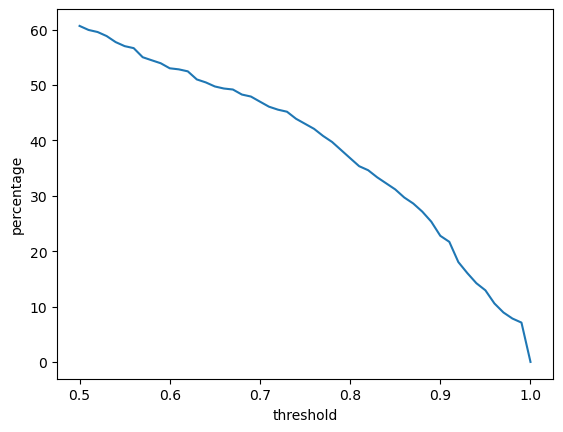

In [95]:
sns.lineplot(data = correlation_percentages, x='threshold',y='percentage')

In [122]:
#we select features with correlation below .85
selected_features = set(df.columns).difference(high_corr_features)
selected_features_ix = list(map(lambda feature: True if feature in list(selected_features) else False, df.columns))

In [125]:
first_reduction_df = df.loc[:,selected_features_ix].copy()

In [126]:
first_reduction_df

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,...,Feature_534,Feature_535,Feature_537,Feature_538,Feature_540,Feature_541,Feature_542,Feature_543,Feature_545,Target
0,0.144231,0.105263,0.9000,0.66665,0.0,0.0,NaN,NaN,0.56250,0.166667,...,0.2768,0.0,0.00,One Ring,0.216696,0.0000,0.000000,Orcs,0.00,0
1,0.115385,0.000000,0.8750,0.00000,0.0,0.0,0.000000,0.028192,0.56000,0.250000,...,0.4267,0.0,0.00,Sting,0.058615,0.0105,0.000000,Goblins,1.00,0
2,0.076923,0.000000,0.8750,0.50000,0.0,1.0,0.000000,0.027882,0.63335,0.083333,...,0.2896,0.0,0.00,Sting,0.000000,0.0000,0.263682,Uruk-hai,0.00,0
3,0.076923,0.000000,0.8750,0.00000,0.0,0.0,0.000000,NaN,0.78570,0.416667,...,0.2781,0.0,0.00,Anduril,0.000000,0.0000,0.000000,Goblins,1.00,0
4,0.528846,0.263158,0.9375,0.87500,0.0,1.0,0.000000,0.027882,0.56865,0.583333,...,0.3093,0.0,0.00,Glamdring,0.033748,0.0130,0.094527,Uruk-hai,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2558,0.096154,0.000000,0.7500,0.00000,0.0,0.0,0.000000,0.027882,0.61110,0.166667,...,0.2941,0.0,0.00,Arkenstone,0.000000,0.0000,0.000000,Nazgul,0.00,1
2559,0.115385,0.000000,1.0000,0.00000,0.0,1.0,0.000000,0.027882,0.50000,0.166667,...,0.3714,0.0,0.25,Anduril,0.085258,0.0000,0.119403,Goblins,0.75,0
2560,0.096154,0.000000,1.0000,1.00000,0.0,1.0,0.000000,0.244122,0.62500,0.083333,...,0.1844,0.0,0.00,Narsil,0.000000,0.0000,0.000000,Balrog,0.00,0
2561,0.105769,0.000000,1.0000,0.87500,0.0,0.0,0.000000,0.027882,0.50000,0.083333,...,0.2464,0.0,0.00,Glamdring,0.000000,0.0000,0.000000,Uruk-hai,0.00,0


# Data Transformation

In [3]:
def convert_to_categorical(data: pd.DataFrame, max_unique_values=20):
    """
    Convert features with 20 or fewer unique values to categorical features in a DataFrame.

    Parameters:
    - data (pd.DataFrame): Input DataFrame.
    - max_unique_values (int): Maximum number of unique values allowed (default is 20).

    Returns:
    - pd.DataFrame: DataFrame with selected features converted to categorical.

    Example:
    ```
    import pandas as pd

    # Create a sample DataFrame
    data = {'Feature1': ['A', 'B', 'A', 'B', 'A'],
            'Feature2': [1, 2, 3, 3, 3],
            'Feature3': [100, 200, 100, 200, 300]}

    df = pd.DataFrame(data)

    # Convert features to categorical
    categorical_df = convert_to_categorical(df)
    ```
    """
    data_aux = data.copy()
    # Identify features with 20 or fewer unique values
    selected_features = data_aux.columns[data_aux.nunique() <= max_unique_values]

    # Convert selected features to categorical
    data_aux[selected_features] = data_aux[selected_features].astype('object')

    return data_aux


In [9]:
def fill_missing_values(data: pd.DataFrame, numeric_strategy='mean', categorical_strategy='most_frequent'):
    """
    Fill missing values in both numeric and categorical columns of a DataFrame.

    Parameters:
    - data (pd.DataFrame): Input DataFrame.
    - numeric_strategy (str): Strategy for filling missing values in numeric columns.
      Options: 'mean' (default), 'median', 'constant', etc.
    - categorical_strategy (str): Strategy for filling missing values in categorical columns.
      Options: 'most_frequent' (default), 'constant', etc.

    Returns:
    - pd.DataFrame: DataFrame with missing values filled.

    Example:
    ```
    import pandas as pd

    # Create a sample DataFrame
    data = {'NumericColumn': [1, 2, None, 4, 5],
            'CategoricalColumn': ['A', 'B', None, 'A', 'B']}

    df = pd.DataFrame(data)

    # Apply missing value filling
    filled_df = fill_missing_values(df)
    ```
    """
    data_aux = data.copy()
    # Separate numeric and categorical columns
    numeric_cols = data_aux.select_dtypes(include='number').columns
    categorical_cols = data_aux.select_dtypes(include='object').columns
    
    # Fill missing values in numeric columns
    data_aux[numeric_cols] = data_aux[numeric_cols].fillna(data_aux[numeric_cols].agg(numeric_strategy))
    
    # Fill missing values in categorical columns
    data_aux[categorical_cols] = data_aux[categorical_cols].fillna(data_aux[categorical_cols].mode().iloc[0] if categorical_strategy == 'most_frequent' else categorical_strategy)
    return data_aux

# Dimensionality Reduction

In [4]:
def correlation_reduction(data: pd.DataFrame, threshold=0.85):
    """
    Reduce dimensionality of a DataFrame by excluding features with high correlation.

    Parameters:
    - data (pd.DataFrame): Input DataFrame.
    - threshold (float): Threshold for high correlation (default is 0.85).

    Returns:
    - pd.DataFrame: DataFrame with reduced dimensionality, excluding high correlation features.

    Example:
    ```
    import pandas as pd

    # Create a sample DataFrame
    data = {'Feature1': [1, 2, 3, 4, 5],
            'Feature2': [5, 4, 3, 2, 1],
            'Feature3': [1, 2, 3, 4, 5],
            'Feature4': [5, 4, 3, 2, 1]}

    df = pd.DataFrame(data)

    # Apply correlation reduction
    reduced_df = correlation_reduction(df)
    ```
    """

    # Copy the original DataFrame up to the specified number of columns excluding target
    data_aux = data.iloc[:, :548].copy()

    # Calculate the correlation matrix
    correlation_matrix = data_aux.corr()

    # Identify features with high correlation
    high_corr_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                high_corr_features.add(colname)

    # Select features with correlation below the threshold
    selected_features = set(data_aux.columns).difference(high_corr_features)
    selected_features_ix = list(map(lambda feature: True if feature in list(selected_features) else False, data_aux.columns))

    # Create a reduced DataFrame
    reduction_df = data_aux.loc[:, selected_features_ix].copy()

    return reduction_df

In [5]:
def split_data_by_dtype(data: pd.DataFrame):
    """
    Split a DataFrame into two DataFrames based on numeric and categorical features.

    Parameters:
    - data (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: DataFrame containing only numeric features.
    - pd.DataFrame: DataFrame containing only categorical features.

    Example:
    ```
    import pandas as pd

    # Create a sample DataFrame
    data = {'Numeric1': [1, 2, 3, 4, 5],
            'Numeric2': [5, 4, 3, 2, 1],
            'Categorical1': ['A', 'B', 'A', 'B', 'A'],
            'Categorical2': ['X', 'Y', 'X', 'Y', 'Z']}

    df = pd.DataFrame(data)

    # Split the DataFrame
    numeric_df, categorical_df = split_data_by_dtype(df)
    ```
    """
    data_aux = data.copy()
    # Identify numeric and categorical columns
    numeric_cols = data_aux.select_dtypes(include='number').columns
    categorical_cols = data_aux.select_dtypes(include='object').columns

    # Create DataFrames based on column types
    numeric_df = data_aux[numeric_cols].copy()
    categorical_df = data_aux[categorical_cols].copy()

    return numeric_df, categorical_df

In [6]:
def drop_constants_and_high_cardinality(data: pd.DataFrame, max_unique_values=2000):
    """
    Drop features that are constants and have more than a specified number of unique values.

    Parameters:
    - data (pd.DataFrame): Input DataFrame.
    - max_unique_values (int): Maximum number of unique values allowed (default is 2000).

    Returns:
    - pd.DataFrame: DataFrame with constant and high-cardinality features dropped.

    Example:
    ```
    import pandas as pd

    # Create a sample DataFrame
    data = {'Feature1': [1, 2, 3, 4, 5],
            'Feature2': [5, 5, 5, 5, 5],
            'Feature3': ['A', 'B', 'A', 'B', 'A'],
            'Feature4': ['X', 'Y', 'X', 'Y', 'Z']}

    df = pd.DataFrame(data)

    # Drop constants and high-cardinality features
    filtered_df = drop_constants_and_high_cardinality(df)
    ```
    """
    data_aux = data.copy()
    # Drop constant features
    non_constant_cols = data_aux.columns[data_aux.nunique() > 1]
    data_aux = data_aux[non_constant_cols]

    # Drop high-cardinality features
    high_cardinality_cols = data_aux.columns[data_aux.nunique() > max_unique_values]
    data_aux = data_aux.drop(columns=high_cardinality_cols)

    return data_aux

(0.0, 40.0)

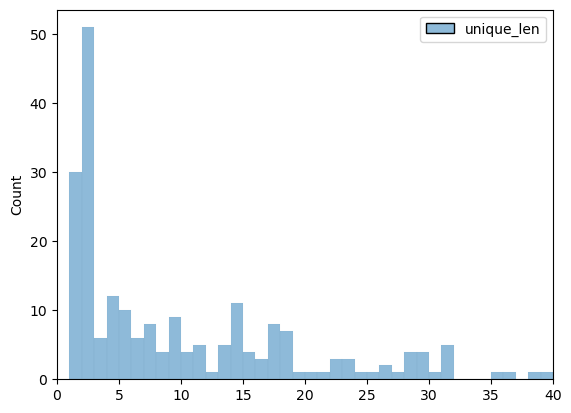

In [194]:
numeric_columns_unique_len = []
for column in numeric_df.columns:
    numeric_columns_unique_len.append(len(numeric_df[column].unique()))
numeric_columns_unique_len_df = pd.DataFrame({
    'feature':numeric_df.columns,
    'unique_len': numeric_columns_unique_len
})
sns.histplot(numeric_columns_unique_len_df.sort_values('unique_len'), binwidth= 1)
plt.xlim(0,40)

In [7]:
def reduce_dimensionality(data: pd.DataFrame, n_components=None):
    """
    Perform dimensionality reduction using PCA and print explained variance and most important features.

    Parameters:
    - data (pd.DataFrame): Input DataFrame.
    - n_components (int): Number of principal components. If None (default), it uses the number of features.

    Returns:
    - pd.DataFrame: DataFrame with reduced dimensionality.

    Example:
    ```
    import pandas as pd

    # Create a sample DataFrame
    data = {'Feature1': [1, 2, 3, 4, 5],
            'Feature2': [5, 4, 3, 2, 1],
            'Feature3': [1, 2, 3, 4, 5]}

    df = pd.DataFrame(data)

    # Apply dimensionality reduction
    reduced_df = reduce_dimensionality(df)
    ```
    """
    data_aux = data.copy()
    # Standardize the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_aux)

    # Apply PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_data)

    # Create a DataFrame with principal components
    pc_columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
    pc_df = pd.DataFrame(data=principal_components, columns=pc_columns)

    # Print explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained Variance Ratio:")
    print(explained_variance_ratio.sum())

    # Print most important features for each principal component
    #print("\nMost Important Features for Each Principal Component:")
    #for i, component in enumerate(pca.components_):
    #    top_features = np.abs(component).argsort()[::-1][:5]  # Top 5 features
    #    feature_names = data.columns[top_features]
    #    print(f"PC{i+1}: {feature_names}")

    return pc_df

In [10]:
df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_540,Feature_541,Feature_542,Feature_543,Feature_544,Feature_545,Feature_546,Feature_547,Feature_548,Target
0,0.144231,0.105263,0.9000,0.66665,0.93750,0.0,0.0,NaN,NaN,0.56250,...,0.216696,0.0000,0.000000,Orcs,0.3,0.0,0.294118,0.111111,0.0,0
1,0.115385,0.000000,0.8750,0.00000,0.94000,0.0,0.0,0.0,0.028192,0.56000,...,0.058615,0.0105,0.000000,Goblins,0.1,1.0,0.235294,0.222222,1.0,0
2,0.076923,0.000000,0.8750,0.50000,0.86665,0.0,1.0,0.0,0.027882,0.63335,...,0.000000,0.0000,0.263682,Uruk-hai,0.4,0.0,0.117647,0.222222,0.0,0
3,0.076923,0.000000,0.8750,0.00000,0.71430,0.0,0.0,0.0,NaN,0.78570,...,0.000000,0.0000,0.000000,Goblins,0.0,1.0,0.117647,0.222222,0.0,0
4,0.528846,0.263158,0.9375,0.87500,0.93135,0.0,1.0,0.0,0.027882,0.56865,...,0.033748,0.0130,0.094527,Uruk-hai,0.3,1.0,0.117647,0.666667,1.0,0


In [17]:
df.nunique().sort_values().head(90)

Feature_43     1
Feature_295    1
Feature_289    1
Feature_112    1
Feature_310    1
              ..
Feature_385    3
Feature_215    3
Feature_392    3
Feature_76     3
Feature_162    3
Length: 90, dtype: int64

In [353]:
def preprocess_data(data: pd.DataFrame):
    """
    Perform a series of data preprocessing steps on a DataFrame.

    Steps:
    1. Fill missing values using the `fill_missing_values` function.
    2. Reduce dimensionality due to high correlation using the `correlation_reduction` function.
    3. Convert features with 20 or fewer unique values to categorical using the `convert_to_categorical` function.
    4. Drop constant and high-cardinality features using the `drop_constants_and_high_cardinality` function.
    5. Split the preprocessed DataFrame into numeric and categorical parts using the `split_data_by_dtype` function.
    6. Reduce dimensionality of numeric features using the `reduce_dimensionality` function.
    7. Encode categorical features using one-hot encoding.
    8. Concatenate the reduced numeric and encoded categorical features.

    Parameters:
    - data (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: Preprocessed DataFrame with reduced dimensionality.

    Example:
    ```
    import pandas as pd

    # Create a sample DataFrame
    data = ...

    # Apply preprocessing
    preprocessed_data = preprocess_data(data)
    ```
    """
    # Step 1: Fill missing values
    r0 = fill_missing_values(data)

    # Step 2: Reduce dimensionality due to high correlation
    r1 = correlation_reduction(r0, threshold=0.85)

    # Step 3: Convert features to categorical
    r2 = convert_to_categorical(r1, max_unique_values=20)

    # Step 4: Drop constants and high-cardinality features
    r3 = drop_constants_and_high_cardinality(data=r2, max_unique_values=2000)

    # Step 5: Split the DataFrame into numeric and categorical parts
    r3_numeric, r3_categorical = split_data_by_dtype(r3)

    # Step 6: Reduce dimensionality of numeric features
    r3_numeric_reduced = reduce_dimensionality(r3_numeric, n_components=50)

    # Step 7: Encode categorical features
    r3_categorical_encoded = pd.get_dummies(r3_categorical)

    # Step 8: Concatenate the reduced numeric and encoded categorical features
    r4 = pd.concat([r3_numeric_reduced, r3_categorical_encoded], axis=1)

    return r4

# Model baseline

In [354]:
X = preprocess_data(df)
y = list(df.Target)

/var/folders/31/dyt7r7tn6pg0ck1ht5tjh1mm0000gp/T/ipykernel_59553/3456757575.py:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_aux.corr()


Explained Variance Ratio:
0.6277031271851157


/var/folders/31/dyt7r7tn6pg0ck1ht5tjh1mm0000gp/T/ipykernel_59553/4047443362.py:51: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  r3_categorical_encoded = pd.get_dummies(r3_categorical)
/var/folders/31/dyt7r7tn6pg0ck1ht5tjh1mm0000gp/T/ipykernel_59553/4047443362.py:51: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  r3_categorical_encoded = pd.get_dummies(r3_categorical)
/var/folders/31/dyt7r7tn6pg0ck1ht5tjh1mm0000gp/T/ipykernel_59553/4047443362.py:51: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  r3_categorical_encoded = pd.get_dummies(r3_categorical)
/var/folders/31/dyt7r7tn6pg0ck1ht5tjh1mm0000gp/T/ipykernel_59553/4047443362.py:51: FutureWarning: In a future version, the Inde

In [355]:
X.shape

(2563, 1143)

In [357]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Crear un objeto DMatrix para los datos de entrenamiento y prueba
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definir los parámetros del modelo
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.05,
    'eval_metric': 'logloss'
}

# Entrenar el modelo
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(dtest)

# Convertir las probabilidades en etiquetas binarias
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Precisión del modelo: {accuracy * 100:.2f}%')

Precisión del modelo: 87.99%


In [358]:
y_pred

array([0.08910093, 0.0981841 , 0.08801404, 0.07809025, 0.15972336,
       0.05794271, 0.14322232, 0.04116838, 0.07132006, 0.06920005,
       0.05010118, 0.15057175, 0.07791011, 0.14084786, 0.1363549 ,
       0.05063958, 0.11001829, 0.12705068, 0.08169809, 0.1275111 ,
       0.13062422, 0.04556823, 0.0881349 , 0.07268659, 0.08699444,
       0.21742645, 0.2086022 , 0.06438097, 0.06941312, 0.18559588,
       0.04723737, 0.17566824, 0.08739731, 0.21541607, 0.1416185 ,
       0.08666658, 0.12451979, 0.12994939, 0.10497423, 0.06070951,
       0.25941515, 0.11735626, 0.06351602, 0.05338728, 0.05955268,
       0.13328427, 0.14823352, 0.07283406, 0.12613107, 0.13056178,
       0.08676586, 0.32626122, 0.05011897, 0.15278643, 0.08750074,
       0.11062703, 0.08996493, 0.19170831, 0.10493091, 0.10150865,
       0.05836445, 0.2163926 , 0.14573063, 0.0569943 , 0.09784219,
       0.04945558, 0.08579854, 0.08407371, 0.07481839, 0.09893616,
       0.22399493, 0.13742457, 0.07903464, 0.14616416, 0.10190